## Applying a custom loss -- training for Maximum Quadratic Mutual Information (QMI)
### Hoda Akl
EEL6814 -- Project 2 . <br>
I-	design an autoencoder network, which projects data to a subspace to obtain features that can be then used for classification. You will use again the fashion MNIST that you used for project 1. We will compare two different approaches: First the stacked auto encoder – SAE (5 hidden layers) trained with MSE as found in the literature. Then you can use an MLP or a SVM as the classifier for the bottleneck layer outputs (features) of the trained SAE. Use the CNN classifier as a comparison and explain the results. 	
I suggest the SAE layers to be 500-200-XXX, i.e. the number of units XXX of the bottleneck layer (which selects the dimensionality of the feature space) is selected by you, and it should be as small as possible for good generalization. You should experiment with several bottleneck layer sizes, and explain your criterion for selection. <br>

II-	discard the decoder part of the SAE network after the bottleneck layer, i.e. keep a 2 hidden layer MLP with XXX outputs, and train it with the maximum quadratic mutual information (QMI) loss between the MLP output and the labels. The advantage of the QMI is that it does not require the same number of MLP outputs as labels, which ix`s much more flexible than MSE.  It uses distances between PDFs (functions).


In [ ]:
## Most general notebook 
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import gzip

# Form our test and train data
import tensorflow as tf
from tensorflow import keras
from keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import models 
from tensorflow.keras import layers 
from tensorflow.keras import initializers
from tensorflow.keras.models import load_model
#
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from keras.utils.np_utils import to_categorical
from sklearn.preprocessing import MinMaxScaler
# 
from collections import defaultdict
import keras.backend as K # for the loss function



In [ ]:
import pandas as pd
import numpy as np
import shutil
import os

import torch
from torch import nn as nn

from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, datasets
from torchvision.utils import save_image, make_grid

from sklearn.metrics import confusion_matrix, classification_report, multilabel_confusion_matrix
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import matplotlib.image as mpimg

import seaborn as sns
import time

In [ ]:
from keras.datasets import fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()
# idx_0 = np.where(train_labels == 0)
# idx_1 = np.where(train_labels == 1)
# idxes = np.concatenate((idx_1[0], idx_0[0]), axis=0)
# idxes.shape
# train_images = train_images[idxes, :,:]
# train_labels = train_labels[idxes]
# reshape the data for scaling 
train_img_ln = train_images.reshape(train_images.shape[0], train_images.shape[1]* train_images.shape[2])
test_img_ln = test_images.reshape(test_images.shape[0], test_images.shape[1]* test_images.shape[2])
# scaling the data on the train set
scl = MinMaxScaler()
scl.fit(train_img_ln)
# transform the training and  testing set 
train_img_scl_ln = scl.transform(train_img_ln)
test_img_scl_ln = scl.transform(test_img_ln)
# one hot encode the training and testing labels 
train_labels_onehot = to_categorical(train_labels)
test_labels_onehot  = to_categorical(test_labels)
# split the data into validation and training 
X_Train,X_Val,Y_Train_oneHot,Y_Val_oneHot = train_test_split(train_img_scl_ln,train_labels_onehot, test_size=0.1, random_state=42, shuffle = True)

4423680/4422102 [==============================] - 0s 0us/step


In [ ]:
# def QMI_VJ(sigma = .1):
#   sigma = sigma
def qmi_vj_term(y_true, y_pred, sigma):
    sigma = sigma
    y_true = tf.cast(y_true, 'float32')
    y_pred = tf.cast(y_pred, 'float32')
    y_true_label = tf.argmax(y_true, axis = 1)
    labels, d = tf.unique(y_true_label)
    s = 0
    s = tf.cast(s, 'float32')
    
    for i in labels: 
        
        idx = tf.where(tf.equal(y_true_label, i))
        NP  = len(idx)
        y_pred_little_mat = tf.gather(y_pred, idx)
        y_pred_tiled =tf.tile(y_pred_little_mat, (NP,1,1))
        y_pred_repeat = tf.repeat(y_pred_little_mat, NP, axis = 0)
        difference_mat = y_pred_tiled - y_pred_repeat
        diff_sq = K.square(difference_mat)
        dis_sq = K.sum(diff_sq, axis = 1)
        dis_arr = K.sqrt(dis_sq)
        NormConsNum = (1/(sigma*np.sqrt(2*np.pi)))
        normConsTn = tf.cast(NormConsNum, 'float32')
        sigma = tf.cast(sigma, 'float32')
        gauss_mat =normConsTn* K.exp(-.5*(dis_arr/sigma)**2)
        s += K.sum(gauss_mat)
    
    ktn = tf.constant(200**2, 'float32')
    vj =  s/ ktn
    return vj


# def QMI_VJ(sigma = .1):
#   sigma = sigma
def qmi_vc_term_new(y_true, y_pred, sigma):
    Nsamps = 200
    sigma = sigma
    y_true = tf.cast(y_true, 'float32')
    y_pred = tf.cast(y_pred, 'float32')
    y_true_label = tf.argmax(y_true, axis = 1)
    labels, d = tf.unique(y_true_label)
    sigma = tf.cast(sigma, 'float32')
    NormConsNum = (1/(sigma*np.sqrt(2*np.pi)))
    normConsTn = tf.cast(NormConsNum, 'float32')
    s = 0
    s = tf.cast(s, 'float32')
    N = tf.constant(Nsamps)
    for i in labels: 
        idx = tf.where(tf.equal(y_true_label, i))
        NP  = len(idx)
        for ii in idx:
            # class_spec_sample = tf.gather(y_pred, tf.constant(ii, 'int64'))
            class_spec_sample = tf.gather(y_pred, ii)
            y_pred_repeat_one_sample = tf.repeat(class_spec_sample, N, axis = 0)
            diff_mat = tf.cast(y_pred_repeat_one_sample, 'float32') - tf.cast(y_pred, 'float32')
            diff_sq = K.square(diff_mat)
            dis_sq = K.sum(diff_sq, axis = 1)
            dis_arr = K.sqrt(dis_sq)
            gauss_mat =normConsTn* K.exp(-.5*(dis_arr/sigma)**2)
            s += tf.cast(NP, 'float32')* K.sum(gauss_mat)
        
        
        
        # gauss_mat =normConsTn* K.exp(-.5*(arguments_mat/sigma)**2)
          
    
    Ncubed = tf.cast(N**3, 'float32')
    vc =  s/ Ncubed
    return vc

def qmi_vm_term(y_true, y_pred, sigma, bn_dim = 2):
    Nsamps = 200
    sigma = sigma
    y_true = tf.cast(y_true, 'float32')
    y_pred = tf.cast(y_pred, 'float32')
    y_true_label = tf.argmax(y_true, axis = 1)
    labels, d = tf.unique(y_true_label)
    sigma = tf.cast(sigma, 'float32')
    NormConsNum = (1/(sigma*np.sqrt(2*np.pi)))
    normConsTn = tf.cast(NormConsNum, 'float32')
    s = 0
    s = tf.cast(s, 'float32')
    pre_f = 0 
    pre_f = tf.cast(pre_f, 'float32')
    N = tf.constant(Nsamps)
    # do the loop to get the factor infront of the summation in V_m
    for i in labels: 
        idx = tf.where(tf.equal(y_true_label, i))
        NP  = tf.cast(len(idx), 'float32')
        pre_f += K.square(NP)


    for ii in range(Nsamps):
            y_pred_one_sample = tf.gather(y_pred, ii)
            y_pred_one_sample = tf.reshape(y_pred_one_sample, (1,bn_dim))
            y_pred_repeat_one_sample = tf.repeat(y_pred_one_sample, N, axis = 0)
            diff_mat = tf.cast(y_pred_repeat_one_sample, 'float32') - tf.cast(y_pred, 'float32')
            diff_sq = K.square(diff_mat)
            dis_sq = K.sum(diff_sq, axis = 1)
            dis_arr = K.sqrt(dis_sq)
            gauss_mat =normConsTn* K.exp(-.5*(dis_arr/sigma)**2)
            s +=  K.sum(gauss_mat)          
    
    Npowf = tf.cast(N**4, 'float32')
    pre_f = pre_f/Npowf 
    vm =  pre_f * s
    return vm

def QMI(sigma = .1, bn_dim = 2):
    sigma = sigma
    bn_dim = bn_dim
    def qmi_val(y_true, y_pred): 
        qmi = tf.cast( qmi_vj_term(y_true, y_pred, sigma), 'float32') - tf.cast(2, 'float32')* tf.cast(qmi_vc_term_new(y_true, y_pred, sigma), 'float32') + tf.cast(qmi_vm_term(y_true, y_pred, sigma, bn_dim = bn_dim), 'float32')
        qmi = tf.reduce_sum(qmi)
        return qmi
    return qmi_val

In [ ]:

def create_net(h_dim_1_en = 500, h_dim_2_en = 200, BN_dim = 2 , nout =10, img_dim_flat = 28*28, act_last = None):

    model = models.Sequential()
    model.add(layers.Dense(h_dim_1_en, activation = 'relu', input_shape = (img_dim_flat,)))
    model.add(layers.Dense(h_dim_2_en, activation = 'relu'))
    # model.add(layers.Dense(BN_dim, activation = 'relu'))
    model.add(layers.Dense(BN_dim, activation = act_last))


    return model

In [ ]:
# maximizing the QMI by using negative learning rate
bn_dim = 5
sigma = 1.0
model_all_bn5 = create_net(BN_dim = bn_dim, act_last = None)
lr =0.001
opt = tf.keras.optimizers.Adam(learning_rate =-lr)
model_all_bn5.compile(optimizer=opt, loss=QMI(sigma = sigma, bn_dim = bn_dim), metrics=['accuracy'])
# )
# print_weights = LambdaCallback(on_epoch_end=lambda batch, logs: print(model.layers[0].get_weights()))
# callbacks = [EarlyStopping(monitor='val_loss', patience=20),
                #  ModelCheckpoint(filepath='qmi_2_classes.h5', monitor='val_loss', save_best_only=True)]
history_all_bn5 = model_all_bn5.fit(X_Train,Y_Train_oneHot,
                          epochs=50,
                          batch_size=200, verbose = 1)
                    # ,callbacks = [print_weights])

In [ ]:
# maximizing the QMI by using negative learning rate
bn_dim = 10
sigma = 1.0
model_all_bn10 = create_net(BN_dim = bn_dim, act_last = None)
lr =0.001
opt = tf.keras.optimizers.Adam(learning_rate =-lr)
model_all_bn10.compile(optimizer=opt, loss=QMI(sigma = sigma, bn_dim = bn_dim), metrics=['accuracy'])
# )
# print_weights = LambdaCallback(on_epoch_end=lambda batch, logs: print(model.layers[0].get_weights()))
# callbacks = [EarlyStopping(monitor='val_loss', patience=20),
                #  ModelCheckpoint(filepath='qmi_2_classes.h5', monitor='val_loss', save_best_only=True)]
history_all_bn10 = model_all_bn10.fit(X_Train,Y_Train_oneHot,
                          epochs=50,
                          batch_size=200, verbose = 1)
                    # ,callbacks = [print_weights])

In [ ]:
# maximizing the QMI by using negative learning rate
bn_dim = 20
sigma = 1.0
model_all_bn20 = create_net(BN_dim = bn_dim, act_last = None)
lr =0.001
opt = tf.keras.optimizers.Adam(learning_rate =-lr)
model_all_bn20.compile(optimizer=opt, loss=QMI(sigma = sigma, bn_dim = bn_dim), metrics=['accuracy'])
# )
# print_weights = LambdaCallback(on_epoch_end=lambda batch, logs: print(model.layers[0].get_weights()))
# callbacks = [EarlyStopping(monitor='val_loss', patience=20),
                #  ModelCheckpoint(filepath='qmi_2_classes.h5', monitor='val_loss', save_best_only=True)]
history_all_bn20 = model_all_bn20.fit(X_Train,Y_Train_oneHot,
                          epochs=50,
                          batch_size=200, verbose = 1)
                    # ,callbacks = [print_weights])

Text(0.5, 1.0, 'QMI vs Iterations - 10 classes')

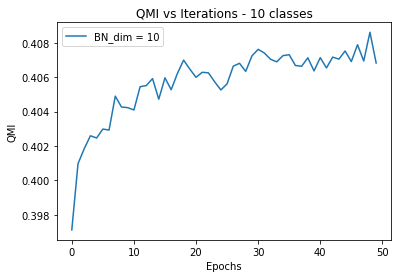

In [ ]:
# loss10 =  np.asarray(history_all_bn10.history['loss']) 
# loss5 =  np.asarray(history_all_bn5.history['loss']) 
loss20 =  np.asarray(history_all_bn20.history['loss']) 
# plt.plot(loss5, label = 'BN_dim = 5')

plt.plot(loss10, label = 'BN_dim = 10')
# plt.plot(loss20, label = 'BN_dim = 20')

plt.legend()
plt.xlabel('Epochs')
plt.ylabel('QMI')
plt.title('QMI vs Iterations - 10 classes')
#s = 1, no activation